In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

train_test_random_state = 123

In [55]:
def dropInsignificant(X, y):
	model = sm.OLS(y, X).fit()

	# Calculate reduced model
	mod_temp = model
	X_temp = X
	while max(mod_temp.pvalues[1:]) > 0.05 and (len(X_temp.columns) > 1):
		max_pvalue = np.argmax(mod_temp.pvalues[1:])+1
		X_temp = X_temp.drop(columns = X_temp.columns[max_pvalue])
		mod_temp = sm.OLS(y, X_temp).fit()
	model = mod_temp

	# Return reduced model
	return model, X_temp

In [56]:
def plotRelationships(axs, dataset, predictors, y):
    for i in range(len(predictors)):
        row = i // 2
        col = i % 2
        axs[row, col].scatter(dataset[predictors[i]], y)
        axs[row, col].set_title(f'{predictors[i]} vs. Shares')
        axs[row, col].set_xlabel(predictors[i])
        axs[row, col].set_ylabel('Shares')

In [57]:
# Import data
raw_data = pd.read_csv('OnlineNewsPopularity.csv')

In [58]:
# Separate into X and y
non_predictive_columns = ['url', 'timedelta']
target = ['shares']

X = raw_data.drop(columns=non_predictive_columns + target)
X_with_const = sm.add_constant(X)
y = raw_data['shares']

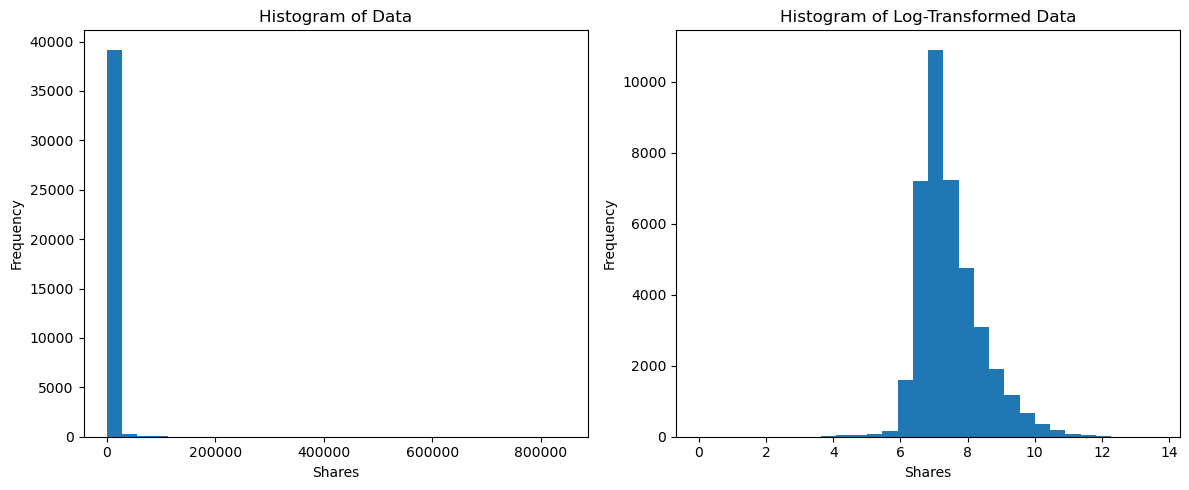

In [59]:
''' Plot target variable '''
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot original data histogram
axs[0].hist(y, bins=30)
axs[0].set_title('Histogram of Data')
axs[0].set_xlabel('Shares')
axs[0].set_ylabel('Frequency')

# Plot log-transformed data histogram
axs[1].hist(np.log(y), bins=30)
axs[1].set_title('Histogram of Log-Transformed Data')
axs[1].set_xlabel('Shares')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [60]:
''' List the statistically significant variables from linear regression '''
# Call function that drops the insignificant variables
linear_regressor_significant, X_significant = dropInsignificant(X_with_const, y)

In [61]:
X_significant.columns

Index(['const', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'num_hrefs', 'num_self_hrefs',
       'average_token_length', 'data_channel_is_entertainment',
       'data_channel_is_world', 'kw_min_min', 'kw_min_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'LDA_03', 'global_subjectivity', 'global_rate_positive_words',
       'min_positive_polarity', 'avg_negative_polarity'],
      dtype='object')

In [62]:
''' List the importance of the variables from a regression tree '''
# Fit tree
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X, y)

# Get feature importances
feature_importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [63]:
# Display top feature importances
num_important_features = 20
most_important = importance_df.iloc[:num_important_features]
most_important

,Feature,Importance
55,title_sentiment_polarity,0.127941
39,LDA_02,0.102886
40,LDA_03,0.078154
9,average_token_length,0.077426
25,kw_avg_avg,0.068318
46,rate_positive_words,0.062610
28,self_reference_avg_sharess,0.044785
27,self_reference_max_shares,0.029920
24,kw_max_avg,0.028454
38,LDA_01,0.027072


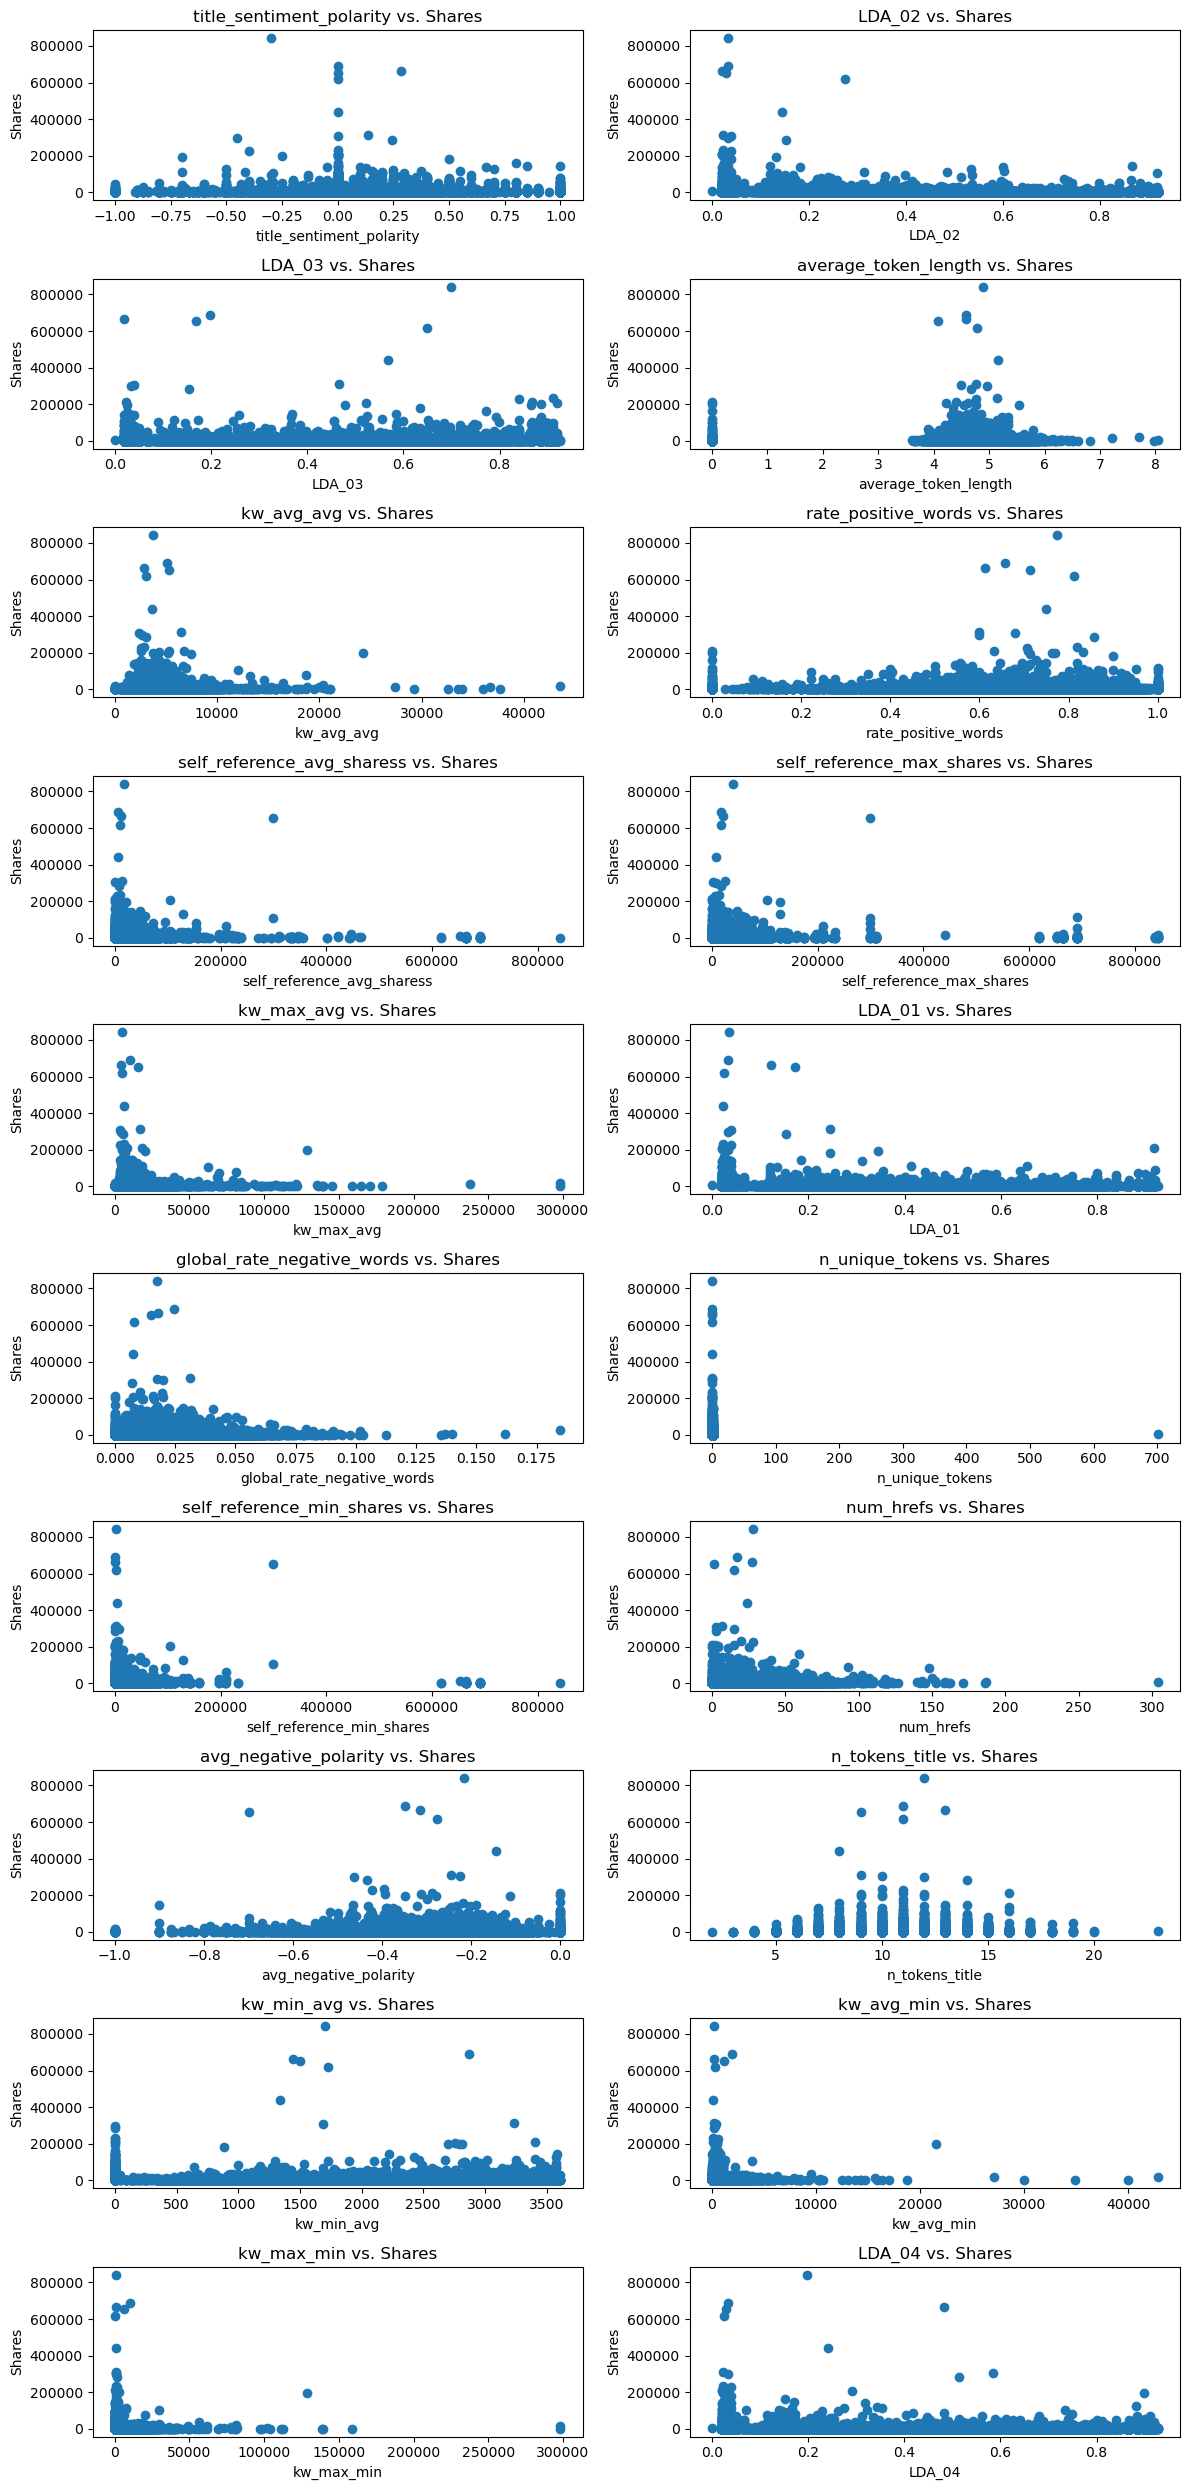

In [64]:
# Plot relationships between the most influential predictors and the target
fig, axs = plt.subplots(int(num_important_features/2), 2, figsize=(12, 25))
predictors = list(importance_df.iloc[0:num_important_features, 0])
plotRelationships(axs, X, predictors, y)

plt.tight_layout()
plt.show()

In [ ]:
# Create the final list of predictors
significant_columns = X_significant.columns
important_columns = list(most_important.iloc[:, 0])
combined_columns = []
for col in significant_columns:
    if col in important_columns:
        combined_columns.append(col)

X_final = X[combined_columns]

In [ ]:
# Print final predictors
X_final.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs',
       'average_token_length', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares', 'LDA_03',
       'avg_negative_polarity'],
      dtype='object')

#### EDA Report
* After observing the histogram of the target, we realized that a log transformation would be useful. Once the log transformation was performed, the distribution of the target became much less skewed.
* After gathering lists of the statistically significant predictors from the linear regression and the top 20 most important predictors from the regression tree, we chose the features that were in both lists and put them in our final list of predictors. We then used these predictors for the remainder of the project.

# Linear Regression Modeling

### Splitting the Data into Training and Testing Sets

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


### Exploring Transformations of the Target and Other Variables

In [69]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### Exploring Higher-Order Terms

#### Split into numeric and categorical columns

In [70]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=[object]).columns

print(numeric_cols)
print(categorical_cols)

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs',
       'average_token_length', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares', 'LDA_03',
       'avg_negative_polarity'],
      dtype='object')
Index([], dtype='object')


#### Get Higher Order terms

In [ ]:
continuous_cols = numeric_cols

# There are no significant categorical columns so I didn't do anything with those

X_train_continuous = X_train[continuous_cols]
X_test_continuous = X_test[continuous_cols]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)
hot_names = poly.get_feature_names_out(continuous_cols)
X_full = pd.DataFrame(X_train_continuous_poly,columns = hot_names)

poly_test = PolynomialFeatures(degree=2, include_bias=False)
X_test_continuous_poly = poly_test.fit_transform(X_test_continuous)
X_test_full = pd.DataFrame(X_test_continuous_poly,columns = hot_names)


### Stepwise model evaluation methods to remove insignificant variables.

In [ ]:
for continuous_col in continuous_cols:
    for continuous_col2 in continuous_cols:
        if continuous_col != continuous_col2:
            interaction_term_name = f"{continuous_col}_x_{continuous_col2}"
            X_full[interaction_term_name] = X_full[continuous_col] * X_full[continuous_col2]
            X_test_full[interaction_term_name] = X_test_full[continuous_col] * X_test_full[continuous_col2]

### LASSO regression to fit the full model and remove insignificant variables

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score

imputer = SimpleImputer(strategy='mean')
X_full_imputed = imputer.fit_transform(X_full)
X_test_full_imputed = imputer.transform(X_test_full)

X_train_imputed = X_full_imputed[:len(X_train)]
X_test_imputed = X_test_full_imputed[:len(X_test)]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_log.values.reshape(-1, 1))
y_test_scaled = y_scaler.fit_transform(y_test_log.values.reshape(-1, 1))

model_best = LassoCV(cv=2)
model_best.fit(X_train_scaled, y_train_scaled)
alpha_best = model_best.alpha_

reg_lasso = Lasso(alpha=alpha_best)
reg_lasso.fit(X_train_scaled, y_train_scaled)

train_preds_lasso = reg_lasso.predict(X_train_scaled)
test_preds_lasso = reg_lasso.predict(X_test_scaled)

r2_train = r2_score(y_train_log, y_scaler.inverse_transform(train_preds_lasso.reshape(-1, 1)))
r2_test = r2_score(y_test_log, y_scaler.inverse_transform(test_preds_lasso.reshape(-1, 1)))

print("In-Sample R^2:", r2_train)
print("Out-of-Sample R^2:", r2_test)


In-Sample R^2: 0.09739109294951365
Out-of-Sample R^2: 0.09491711112391366
